# Evaluating Denoising Efficiency

## Introduction 

Simulated using MIRT as described in [Nelson et al., 2023](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901) where the acquisition parameters are meant to simulate the Siemens Somatom Definition AS+, which is one of the scanners used in developing the [Low Dose CT Grand Challenge Dataset](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.12345). However I still need to be careful that this is an approximation and there still may be mismatch between the real and simulated scans, though [Zeng et al., 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430) validated the simulations with physical scans based on MTF and NPS performance measures.

**Question**: Data augmentation is a common approach for dealing with limited datasets. Can data augmentation techniques be used to make up for limited pediatric data?

**Hypothesis**: Noise textures from pediatric-sized phantom scans can be used as an effective data augmentation to improve denoising model generalizability to pediatric patients.

*Purpose* to test our hypothesis that training with noise augmentation can improve performance in pediatric patients. This notebook presents the results in terms of denoising efficiency, which we define in two ways depending on the data available.

If we assume noise as additive ([double check this assumption](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.poisson.html#numpy.random.Generator.poisson)) then we can say the measured signal is $y=Ax + n$, where $x$ is the map of x-ray attenuation coefficients in the cross-section and $y$ is the measured x-ray projections with added blurring and artifacts from the system matrix $A$ and noise $n$. Image reconstruction then takes the form of $x' = A^{-1}(y - n) ~ A^{-1}y - A^{-1}n$ Thus the idea of image-based denoising assumes that the noise in the CT image is seperable and can be estimated and subtracted  

## Methods: Measures of Noise Reduction
To evaluate the estimation of x' we can define RMSE as a measure of how well we've estimated and thus removed noise from the image.

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x'_i - x_i)^2}
$$



Key to RMSE is assumed knowledge of the ground truth image $x$, which we have access to in simulations. However when we using patient images we don't have access to ground truth, at best we have a low dose and routine dose pair to compare a against to get MSE.

If even that doesn't exist you can select a region that is assumed to be uniform and compare measured standard deviation $\sigma$ in the region:

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i' - \mu)^2},\text{ where } \mu = \frac{1}{N} \sum_{i=1}^N x'_i
$$

here we assume a uniform region such that that $\bar{x}$ is assumed to be the true value for an unbiased measurement in a uniform region

We can thus define noise reduction both in terms of noise std [HU] and RMSE as:

$$
\text{Noise Reduction} = 100\% \times \frac{(\text{FBP} - \text{denoised})}{\text{FBP}}
$$

Defining noise reduction relative to the original FBP noise level

## Outline
- [Noise Reduction in Uniform Phantoms](#Noise-Reduction-in-Uniform-Phantoms)
- [Noise Reduction in Anthropomorphic Phantoms](#Noise-Reduction-in-Anthropomorphic-Phantoms)
- [Putting it all together: denoising trends with phantom size](#Putting-it-all-together:-plotting-trends)
- [Conclusions](#Conclusions)

Focus is on noise magnitude reduction in uniform phantoms and low dose patient images and RMSE reduction in uniform and anthropomorphic phantoms since ground truth is known.

## Noise Reduction in Uniform Phantoms

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import SimpleITK as sitk

import sys
# sys.path.append('..')

from utils import circle_select, get_circle_diameter, load_mhd, ctshow, make_montage, add_random_circle_lesion, get_ground_truth, measure_roi_std_results, measure_rmse_results

physical_meta = pd.read_csv(physical_dir / 'metadata.csv')
physical_meta['simulated'] = False
physical_meta.file = physical_meta.file.apply(lambda o: physical_dir / o)
physical_meta = physical_meta[(physical_meta.kernel == 'Qr43')]

phantom_meta = pd.read_csv(phantom_dir / 'metadata.csv')
ctp_meta = pd.read_csv(base_dir / 'CTP404_peds' / 'metadata.csv')

anthro_meta = pd.read_csv(anthro_dir / 'metadata.csv')
anthro_meta['simulated'] = True
anthro_meta['FOV (cm)'] = anthro_meta['effective diameter (cm)']*1.3
anthro_meta.file = anthro_meta.file.apply(lambda o: anthro_dir / o)
meta = pd.concat([anthro_meta, phantom_meta, physical_meta], ignore_index=True)
meta.rename({'effective diameter (cm)' : 'effective diameter [cm]', 'age (year)' : 'age [year]', 'weight (kg)' : 'weight [kg]', 'height (cm)':'height [cm]', 'FOV (cm)': 'FOV [cm]'}, axis='columns', inplace=True)
meta = pd.concat([meta, ctp_meta], ignore_index=True)
# meta.to_csv(base_dir/'metadata.csv', index=False)

If reproducing these figures on your own local dataset, replace `base_dir` with your download location of the dataset available for download at [Zenodo](https://zenodo.org/doi/10.5281/zenodo.10064035)

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11267694.svg)](https://doi.org/10.5281/zenodo.11267694)

These phantom simulations were generated using the [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms), please see the associated [documentation](https://pediatriciqphantoms.readthedocs.io/en/latest/?badge=latest) on how to rerun the simulations under different imaging conditions.

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import SimpleITK as sitk

import sys
sys.path.append('..')

load_dotenv()

from utils import circle_select, get_circle_diameter, load_mhd, ctshow, make_montage, add_random_circle_lesion, get_ground_truth, measure_roi_std_results, measure_rmse_results

ldgc_path = Path(os.environ['LDGC_PATH']) # training dataset

peds_datadir = Path(os.environ['PEDIATRICIQ_PATH']) # testing dataset
anthro_datadir = Path(os.environ['ANTHROPOMORPHIC_PATH']) # testing dataset

if not ldgc_path.exists():
    raise RuntimeError(f'Low Dose Grand Challenge Dataset not found in {ldgc_path}, please download here: <https://aapm.app.box.com/s/eaw4jddb53keg1bptavvvd1sf4x3pe9h/folder/145241244881>')

from torchvision.datasets.utils import download_and_extract_archive
if not peds_datadir.exists():
    download_and_extract_archive(url='https://zenodo.org/records/11267694/files/pediatricIQphantoms.zip', download_root=peds_datadir.parent)

if not anthro_datadir.exists():
    download_and_extract_archive(url='https://zenodo.org/records/12538350/files/anthropomorphic.zip', download_root=anthro_datadir.parent)

In [59]:
dset = PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], fov=12.4)
dset

ValueError: 12.4 not in [12.  12.3 14.  14.4 16.6 17.  20.  20.4 23.8 24.  32.  32.1 34.  38.5
 39. ]

In [40]:
x, y = dset[0]
x.shape, y.shape

((512, 512), (512, 512))

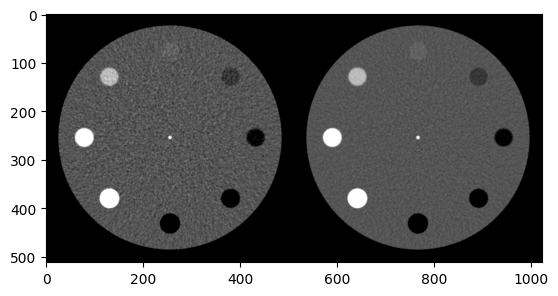

In [45]:
ww, wl = 300, 50
disp = dict(cmap='gray', vmin= wl - ww/2, vmax= wl + ww/2)
plt.imshow(np.concat((x, y), axis=1), **disp)

In [16]:
def load_df(data_dir):
    meta = pd.read_csv(data_dir / 'metadata.csv')
    meta['file'] = meta['file'].apply(lambda o: data_dir / o)
    return meta

meta = pd.concat([load_df(o) for o in (peds_datadir, anthro_datadir)])
meta

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],...,repeat,Code #,gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,simulated,instance
0,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,5.0
396,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,6.0
397,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,7.0
398,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,8.0


In [4]:
for name in meta.Name.unique():
    for dose in meta[meta.Name == name]['Dose [%]'].unique():
        count = len(meta[(meta.Name == name) & (meta['Dose [%]'] == dose)])
        meta.loc[(meta.Name == name) & (meta['Dose [%]'] == dose), 'instance'] = list(range(count))
meta       

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],...,repeat,Code #,gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,simulated,instance
0,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,5.0
396,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,6.0
397,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,7.0
398,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,36.53,...,NaN,151,F,66.4,162.0,25.301021,48.8,white,True,8.0


from dataset_utils import itk_to_dicom

rows = []
for patientid in meta.patientid.unique():
    study = meta[meta.patientid==patientid]
    study.series = 'simulation'

    gt_study = study.iloc[:1].copy()
    gt_study.series = 'ground truth'

    nf_study = study.iloc[:1].copy() #noise free
    nf_study.series = 'noise free'
    gt_study['Dose [%]'] = None

    nf_study['Dose [%]'] = None
    gt_study.recon = None
    gt_study.kernel = None

    if study.phantom.iloc[0] == 'anthropomorphic':
        patient_dir = original_dir / study.Name.iloc[0].replace(' ', '_')
        if str(patient_dir).endswith('yr') or str(patient_dir).endswith('infant'):
            patient_dir = Path(str(patient_dir) + '_ref')
        nf_img = sitk.ReadImage(patient_dir / f"diameter{int(10*study['effective diameter [cm]'].iloc[0]):03d}mm" / 'noise_free.mhd')
        fname = itk_to_dicom(nf_img, fname = Path(study.file.iloc[0]).parents[2] / (study.Name.iloc[0].replace(' ', '_')+'_noisefree.dcm'), patientname=study.Name.iloc[0], patientid=patientid, age=str(int(study['age [year]'].iloc[0])),
                             studyname='pediatric noise texture augmentation', studyid=study.studyid.iloc[0], patient_diameter=study['effective diameter [cm]'].iloc[0], kernel=study['kernel'].iloc[0])
        nf_study = study.iloc[:1].copy() #noise free
        nf_study.file = fname
        # print(fname)
        
        gt_img = sitk.ReadImage(patient_dir / f"diameter{int(10*study['effective diameter [cm]'].iloc[0]):03d}mm" / 'true.mhd')
        fname = itk_to_dicom(gt_img, fname = Path(study.file.iloc[0]).parents[2] / (study.Name.iloc[0].replace(' ', '_')+'_groundtruth.dcm'), patientname=study.Name.iloc[0], patientid=patientid, age=str(int(study['age [year]'].iloc[0])),
                     studyname='pediatric noise texture augmentation', studyid=study.studyid.iloc[0], patient_diameter=study['effective diameter [cm]'].iloc[0], kernel=study['kernel'].iloc[0])
        gt_study.file = fname
    else:
        gt_study.file = list(Path(study.file.iloc[0]).parents[2].glob('*_groundtruth.dcm'))[0]
        nf_study.file = list(Path(study.file.iloc[0]).parents[2].glob('*_noisefree.dcm'))[0]
    rows.append(study)
    rows.append(gt_study)
    rows.append(nf_study)
meta = pd.concat(rows, ignore_index=True)
# meta.file = meta.file.apply(lambda o: Path(o).relative_to(anthro_datadir))
meta.to_csv(anthro_datadir / 'metadata.csv', index=False)

patientid

#### Apply denoiser

In [13]:
import sys
sys.path.append('../head_denoising')

from networks import REDCNN, UNet

unet = UNet.load_from_checkpoint('/projects01/didsr-aiml/brandon.nelson/pediatric_CT_noise_augmentation/lightning_logs/version_6096277/checkpoints/epoch=99-step=166800.ckpt')
unet

UNet(
  (in_conv): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down_convs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
 

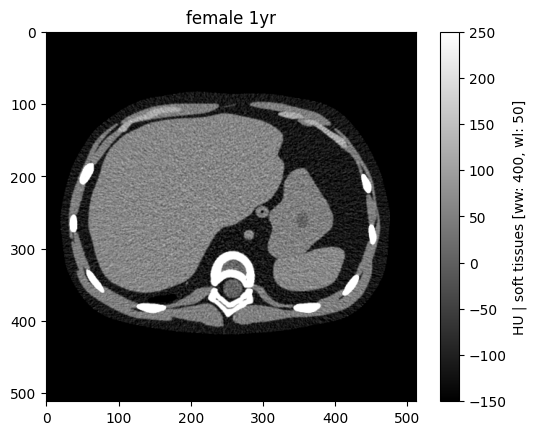

In [6]:
from utils import browse_studies, study_viewer
browse_studies(meta, phantom='anthropomorphic', fov=20.8, dose=100, recon='fbp')

In [7]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404', 'MITA-LCD', 'uniform', 'anthropomorph…

200 files found, taking first


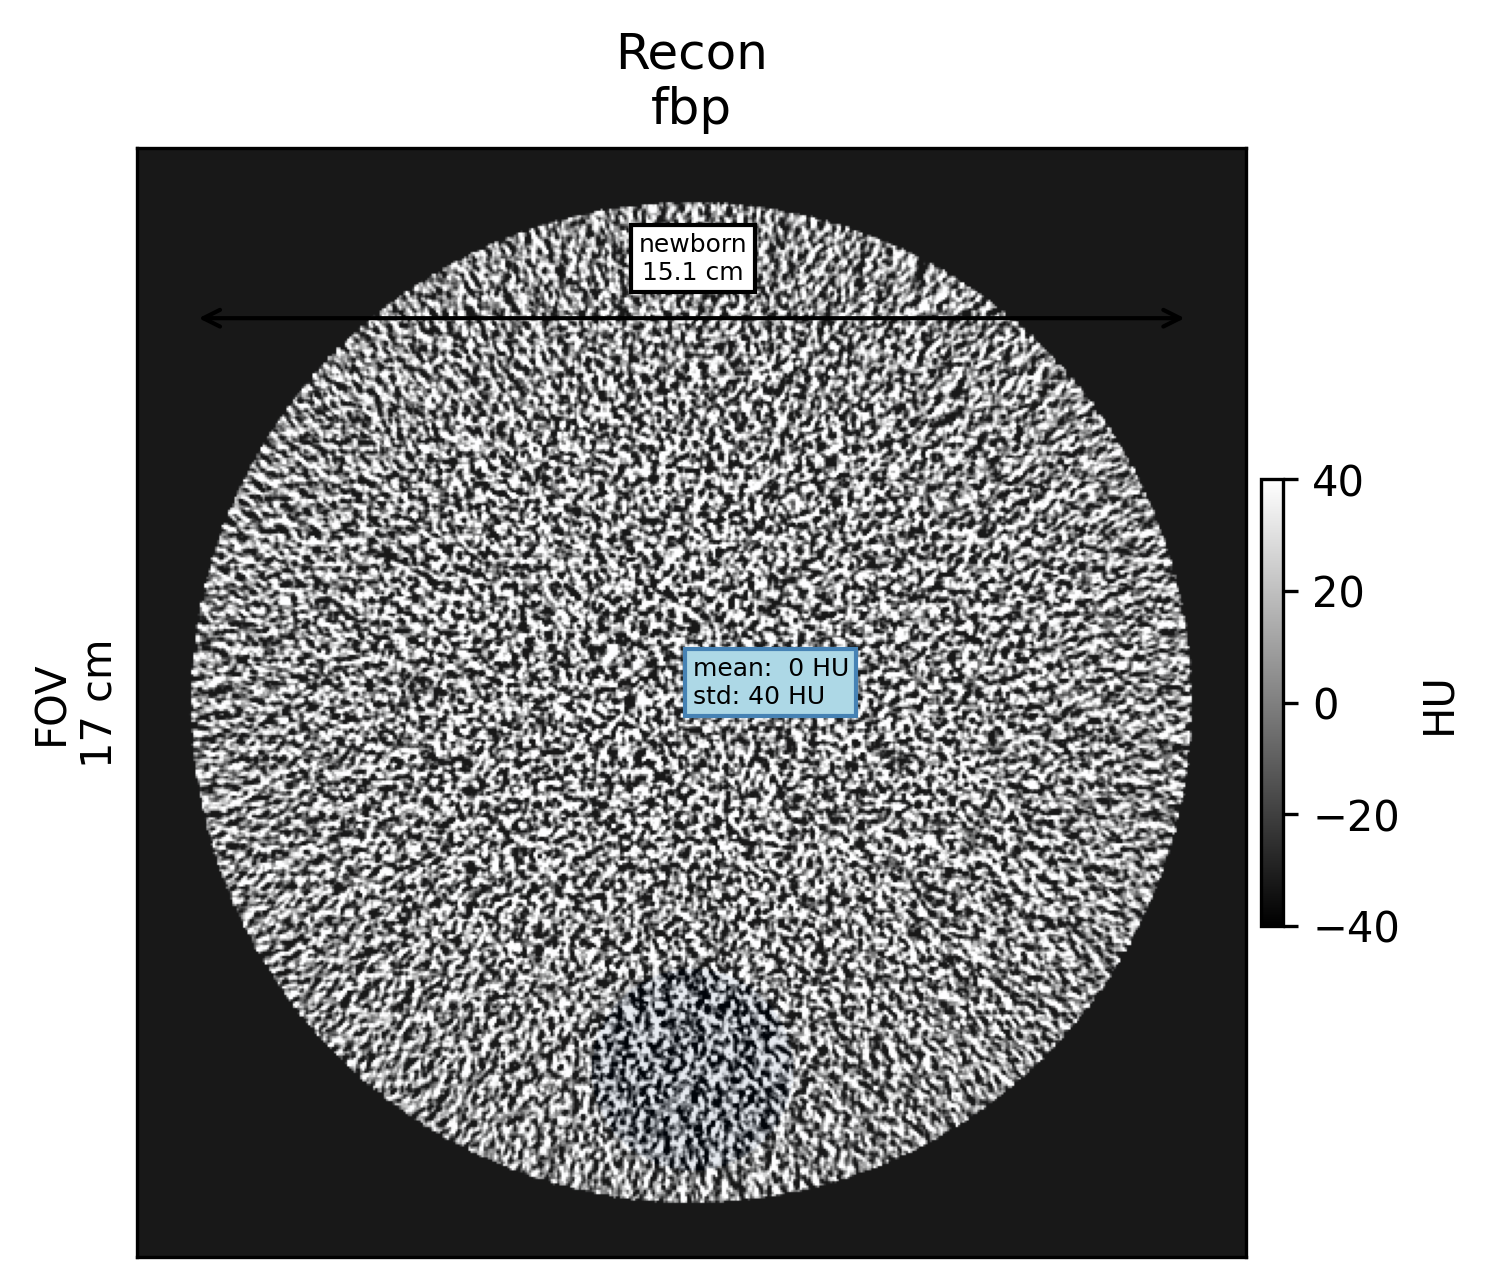

In [8]:
from utils import pediatric_subgroup
meta['pediatric subgroup'] = meta['effective diameter [cm]'].apply(pediatric_subgroup)
f, ax = plt.subplots(dpi=300)
all_imgs = make_montage(meta, phantom='MITA-LCD', recons=['fbp'], roi_diameter=0.2, fovs=[17], roi_center=(425, 256), crop_to_fit=False, figure=f, axis=ax)

### noise std [HU] Reduction in Uniform Phantoms

In [9]:
from utils import noise_reduction
fbp_qd_350 = load_mhd(meta[(meta.recon == 'fbp') &
                           (meta['effective diameter [cm]'] == 35.0) &
                           (meta['Dose [%]'] == 25) &
                           (meta['phantom']=='uniform')].file).squeeze()[0]

fbp_qd_112 = load_mhd(meta[(meta.recon == 'fbp') &
                           (meta['effective diameter [cm]'] == 11.2) &
                           (meta['Dose [%]'] == 25) &
                           (meta['phantom']=='uniform')].file).squeeze()[0]

red_qd_350 = load_mhd(meta[(meta.recon == 'RED-CNN') &
                           (meta['effective diameter [cm]'] == 35.0) &
                           (meta['Dose [%]'] == 25) &
                           (meta['phantom']=='uniform')].file).squeeze()[0]

red_qd_112 = load_mhd(meta[(meta.recon == 'RED-CNN') &
                           (meta['effective diameter [cm]'] == 11.2) &
                           (meta['Dose [%]'] == 25) &
                           (meta['phantom']=='uniform')].file).squeeze()[0]

redaug_qd_350 = load_mhd(meta[(meta.recon == 'RED-CNN augmented') &
                           (meta['effective diameter [cm]'] == 35.0) &
                           (meta['Dose [%]'] == 25) &
                           (meta['phantom']=='uniform')].file).squeeze()[0]

redaug_qd_112 = load_mhd(meta[(meta.recon == 'RED-CNN augmented') &
                           (meta['effective diameter [cm]'] == 11.2) &
                           (meta['Dose [%]'] == 25) &
                           (meta['phantom']=='uniform')].file).squeeze()[0]

phantom_diameter_px = get_circle_diameter(fbp_qd_350)
circle_selection_diameter_px = 0.4*phantom_diameter_px # iec standard suggests centred circle ROI 40% of phantom diameter 
circle_selection = circle_select(fbp_qd_350, xy=(256, 256), r = circle_selection_diameter_px/2)

print(f'Large diameter denoising efficiency [RED-CNN]: %{noise_reduction(fbp_qd_350[circle_selection].std(), red_qd_350[circle_selection].std()):2.2f}')
print(f'Small diameter denoising efficiency [RED-CNN]: %{noise_reduction(fbp_qd_112[circle_selection].std(), red_qd_112[circle_selection].std()):2.2f}')
print('---------------------------------------------------------------')
print(f'Large diameter denoising efficiency [RED-CNN Augmented]: %{noise_reduction(fbp_qd_350[circle_selection].std(), redaug_qd_350[circle_selection].std()):2.2f}')
print(f'Small diameter denoising efficiency [RED-CNN Augmented]: %{noise_reduction(fbp_qd_112[circle_selection].std(), redaug_qd_112[circle_selection].std()):2.2f}')

RuntimeError: Exception thrown in SimpleITK ImageSeriesReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageSeriesReader.cxx:147:
sitk::ERROR: File names information is empty. Cannot read series.

Looks like augmentation lead to better denoising efficiency in the smaller phantom! ^^ [denoised std/fbp std] --> **[30 HU/48 HU] for REDCNN, compared to [19 HU/48 HU] for augmented!**

In [ ]:
fbp_qd_350 = load_mhd(meta[(meta.recon == 'fbp') &
                     (meta['FOV [cm]'] == 38) &
                     (meta['Dose [%]'] == 25) &
                     (meta['phantom']=='ACR464')].file).squeeze()[0] - 0

fbp_qd_112 = load_mhd(meta[(meta.recon == 'fbp') &
                     (meta['FOV [cm]'] == 15) &
                     (meta['Dose [%]'] == 25) &
                     (meta['phantom']=='ACR464')].file).squeeze()[0] - 0

red_qd_350 = load_mhd(meta[(meta.recon == 'RED-CNN') &
                     (meta['FOV [cm]'] == 38) &
                     (meta['Dose [%]'] == 25) &
                     (meta['phantom']=='ACR464')].file).squeeze()[0] - 0

red_qd_112 = load_mhd(meta[(meta.recon == 'RED-CNN') &
                     (meta['FOV [cm]'] == 15) &
                     (meta['Dose [%]'] == 25) &
                     (meta['phantom']=='ACR464')].file).squeeze()[0] - 0

redaug_qd_350 = load_mhd(meta[(meta.recon == 'RED-CNN augmented') &
                     (meta['FOV [cm]'] == 38) &
                     (meta['Dose [%]'] == 25) &
                     (meta['phantom']=='ACR464')].file).squeeze()[0] - 0

redaug_qd_112 = load_mhd(meta[(meta.recon == 'RED-CNN augmented') &
                     (meta['FOV [cm]'] == 15) &
                     (meta['Dose [%]'] == 25) &
                     (meta['phantom']=='ACR464')].file).squeeze()[0] - 0

phantom_diameter_px = get_circle_diameter(fbp_qd_350)
circle_selection_diameter_px = 0.4*phantom_diameter_px # iec standard suggests centred circle ROI 40% of phantom diameter 
circle_selection = circle_select(fbp_qd_350, xy=(256, 256), r = circle_selection_diameter_px/2)

from utils import noise_reduction

print(f'Large diameter denoising efficiency [RED-CNN]: %{noise_reduction(fbp_qd_350[circle_selection].std(), red_qd_350[circle_selection].std()):2.2f}')
print(f'Small diameter denoising efficiency [RED-CNN]: %{noise_reduction(fbp_qd_112[circle_selection].std(), red_qd_112[circle_selection].std()):2.2f}')
print('---------------------------------------------------------------')
print(f'Large diameter denoising efficiency [RED-CNN Augmented]: %{noise_reduction(fbp_qd_350[circle_selection].std(), redaug_qd_350[circle_selection].std()):2.2f}')
print(f'Small diameter denoising efficiency [RED-CNN Augmented]: %{noise_reduction(fbp_qd_112[circle_selection].std(), redaug_qd_112[circle_selection].std()):2.2f}')

In [ ]:
from utils import measure_roi_std_results, calculate_noise_reduction
results_csv = Path('results/results.csv')

overwrite_results = False

if results_csv.exists() and not overwrite_results:
    results = pd.read_csv(results_csv)
else:
    results = measure_rmse_results(meta).rename(columns={'rmse':'RMSE [HU]'})
    results['noise std [HU]'] = measure_roi_std_results(meta)['noise std']
    results = calculate_noise_reduction(results, 'RMSE [HU]')
    results = calculate_noise_reduction(results, 'noise std [HU]').rename(columns={'noise std [HU] reduction [%]':'noise std reduction [%]', 'RMSE [HU] reduction [%]':'RMSE reduction [%]'})
    results.to_csv(results_csv)
results

In [ ]:
results.phantom = results.phantom.replace('ACR464', 'uniform')

In [ ]:
print('RED-CNN 38 cm FOV', results[(results['recon']=='RED-CNN') &
                           (results['Dose [%]'] == 25) &
                           (results['FOV [cm]']==38) &
                           (results['phantom']=='uniform') &
                           (results.simulated==False)]['noise std reduction [%]'].mean())
print('RED-CNN 15 cm FOV', results[(results['recon']=='RED-CNN') &
                           (results['Dose [%]'] == 25) &
                           (results['FOV [cm]']==15) &
                           (results['phantom']=='uniform')]['noise std reduction [%]'].mean())

print('augmented 38 cm FOV', results[(results['recon']=='RED-CNN augmented') &
                           (results['Dose [%]'] == 25) &
                           (results['FOV [cm]']==38) &
                           (results['phantom']=='uniform') &
                           (results.simulated==False)]['noise std reduction [%]'].mean())
print('augmented 15 cm FOV', results[(results['recon']=='RED-CNN augmented') &
                           (results['Dose [%]'] == 25) &
                           (results['FOV [cm]']==15) &
                           (results['phantom']=='uniform')]['noise std reduction [%]'].mean())

### RMSE Reduction in Uniform Phantoms

The original RED-CNN model was most performant on the larger diameter phantom, but noise reduction dropped in the smaller diameter phantom. However, when augmentation is used in training the noise reduction improves in small phantoms! We can expand these measurements to all uniform phantom sizes to get the follow plot and see that our measures above lie on the far extremes of the plot but the trend persists across sizes

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter [cm]'] != 20) &
                          (results.phantom=='uniform') & (results.simulated == True)], x='effective diameter [cm]', y='RMSE [HU]', hue='recon')

In [ ]:
results.phantom.unique()

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results.phantom=='uniform') &
                          (results.simulated==True) &
                          (results.recon != 'fbp')], x='FOV [cm]', y='RMSE reduction [%]', hue='recon')
# plt.savefig('noise_rmse_reduction.png', dpi=600)

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp')], x='FOV [cm]', y='RMSE reduction [%]', hue='recon', style='simulated', style_order=[True, False])

Compared to noise reduction, there isn't as much of a performance gap in adults when measuring RMSE

In [ ]:
f, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 4))
phantom = 'uniform'
sns.lineplot(data=results[(results.phantom==phantom) & (results.simulated==True)], x='FOV [cm]', y='RMSE [HU]', hue='Dose [%]', style='recon',style_order=['RED-CNN', 'RED-CNN augmented'], ax=axs[0])
axs[0].set_title(f'{phantom} phantom simulated data')
sns.lineplot(data=results[(results.phantom==phantom) & (results.simulated==False)], x='FOV [cm]', y='RMSE [HU]', hue='Dose [%]', style='recon',style_order=['RED-CNN', 'RED-CNN augmented'], ax=axs[1])
axs[1].set_title(f'{phantom} phantom real data')

In [ ]:
sns.lineplot(data=results[(results['effective diameter [cm]'] != 20) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp')], x='FOV [cm]', y='RMSE reduction [%]', hue='Dose [%]', style='recon', style_order=['RED-CNN', 'RED-CNN augmented'])

### Side investigation: comparison of adding noise to training vs adding back part of the fbp image?
**TODO** Need to confirm that training side data augmentation is not inferior to just adding back some noise as done above^

In [ ]:
results.head()

In [ ]:
redaug_img = load_mhd(results[(results.recon=='RED-CNN augmented') &
                              (results['Dose [%]']==25) &
                              (results['effective diameter [cm]']==35) &
                              (results['phantom'] == 'uniform')].iloc[0].file)

red_img = load_mhd(results[(results.recon=='RED-CNN') &
                           (results['Dose [%]']==25) &
                           (results['effective diameter [cm]']==35) &
                           (results['phantom'] == 'uniform')].iloc[0].file)

fbp_img = load_mhd(results[(results.recon=='fbp') &
                           (results['Dose [%]']==25) &
                           (results['effective diameter [cm]']==35) &
                           (results['phantom'] == 'uniform')].iloc[0].file).astype('float32')

add_back = red_img + 0.35*(fbp_img - red_img)

In [ ]:
wwwl = (100, 20)
ctshow(np.concatenate([fbp_img[0], red_img[0], add_back[0], redaug_img[0]], axis=1), wwwl)

In [ ]:
wwwl = (100, 20)
ctshow(np.concatenate([fbp_img[0]-fbp_img[1], red_img[0]-red_img[1], add_back[0]-add_back[1], redaug_img[0]-redaug_img[1]], axis=1), wwwl)

In [ ]:
[o.std() for o in [fbp_img[0]-fbp_img[1], red_img[0]-red_img[1], add_back[0]-add_back[1], redaug_img[0]-redaug_img[1]]]

## Noise Reduction in Anthropomorphic Phantoms

Because ground truth is known we can evaluate noise removal as root mean squared error (RMSE) reduction.

We calculate RMSE by comparing the reconstructed image on the left to the ground truth on the right

### noise std [HU] Reduction in Anthropomorphic Phantoms

Calculating noise reduction using standard deviation ROI measurements is slightly more complicated due to the more heterogenous anthropmorphic phantoms. To ensure we are sampling a uniform region and not a boundary region which will give a high std value but not be indicative of noise, we will use this `add_random_circle_lesion` function which takes as an optional argument a `mask` to specify a domain to place the random roi within. 

In [ ]:
from utils import add_random_circle_lesion

In [ ]:
add_random_circle_lesion?

Below we can experiment with some reasonable HU cutoffs to get the liver, note we are doing these thresholds on the ground truth `gt` image so noise is not a factor when getting the mask.

In [ ]:
patient = meta[meta['phantom'] == 'anthropomorphic'].iloc[0]
patient

In [ ]:
from utils import center_crop

In [ ]:
img = center_crop(load_mhd(patient.file)[0])
gt = center_crop(load_mhd(get_ground_truth(patient.file)))
ctshow(img)
plt.colorbar()
mask = (gt >= 50) & (gt < 100)
plt.imshow(mask, alpha=0.4, cmap='Reds') 

In [ ]:
plt.imshow(gt, cmap='gray')

By rerunning the cell below multiple times we see the ROI stays in the liver but in different locations each time

In [ ]:
circle_selection = add_random_circle_lesion(img, mask, radius=50)[1].astype(bool)
ctshow(img)
plt.colorbar()
mask = (gt >= 50) & (gt < 100)
plt.imshow(circle_selection, alpha=0.4, cmap='Reds')
plt.title(f'mean: {img[circle_selection].mean():2.0f} HU\nstd: {img[circle_selection].std():2.0f} HU')

This `add_random_circle_lesion` is built into the `make_montage` visualization function to qualitatively compare noise magnitude reduction across reconstruction types, patient size and other parameters

The doc strings describe that rois can be manually placed using a `tuple` as shown below with `roi_center = (x, y)`

Or alternatively an organ can be specified if using an anthropomorphic phantom and an ROI will be randomly place in that ROI, this is useful for the anthropomorphic phantoms because due to size and placement differences between scans the same roi xy coordinates might not always be in the liver

In [ ]:
def browse_montage(phantom='anthropomorphic', fov=14.43, recon='fbp', roi_center='liver', roi_diameter=0.1, dose=100, wwwl='soft tissues', crop=False):
    make_montage(meta_df=meta, phantom=phantom, roi_center=roi_center, roi_diameter=roi_diameter, fovs=[fov], recons=[recon], dose=dose, wwwl=wwwl, crop_to_fit=crop)

In [ ]:
from ipywidgets import interact, Checkbox
from utils import display_settings
interact(browse_montage,
         phantom=meta.phantom.unique(),
         dose=sorted(meta['Dose [%]'].unique(), reverse=True),
         fov=sorted(meta['FOV [cm]'].unique()),
         recon=meta['recon'].unique(),
         roi_diameter=[0.1, 0.2, 0.3, 0.4, 0.5],
         roi_center=display_settings.keys(),
         wwwl=display_settings.keys(),
         crop=Checkbox(value=False, description='crop image'))

### Figure 4

In [ ]:
from utils import pediatric_subgroup
meta['pediatric subgroup'] = meta['effective diameter [cm]'].apply(pediatric_subgroup)

In [ ]:
f, ax = plt.subplots(dpi=300)
fovs = [35.88, 14.43]
f, ax = make_montage(meta.replace({'fbp':'FBP'}), dose=25,
                     recons = ['FBP', 'RED-CNN', 'RED-CNN augmented'],
                     phantom='anthropomorphic', fovs=fovs, wwwl='soft tissues',
                     roi_center='liver', roi_diameter=0.25, crop_to_fit=True, figure=f, axis=ax)
f.savefig('figures/fig4_anthropomorphic_montage.png', dpi=600)

This anthropomorphic images are supposed to be around the liver, which is uniform so there should be enough space on each image to sample a large circle roi for noise measures

## Putting it all together: plotting trends

In [ ]:
results['is adult'] = results['age [year]'] >= 22

In [ ]:
f, axs = plt.subplots(1, 3, dpi=300, sharex=True, sharey=True, figsize=(18,5))
for ax, dose in zip(axs, [10, 25, 100]):
    legend = False if dose < 100 else True
    sns.scatterplot(ax=ax, data=results[results['Dose [%]']==dose], x='RMSE [HU]', y='noise std [HU]', hue='phantom', style='recon', size='effective diameter [cm]', legend=legend)
    ax.set_title(f'{dose} % dose')

Do RMSE and noise correlate? For the most part yes, (not sure if this plot is super valuable but it addresses the previous point)

In [ ]:
import seaborn as sns
sns.scatterplot(data=results, x='age [year]', y='weight [kg]', hue='is adult')

In [ ]:
sns.scatterplot(data=results, x='age [year]', y='effective diameter [cm]', hue='is adult')

In [ ]:
len(results[results['is adult']==True].Name.unique()), len(results[results['is adult']==False].Name.unique())

In [ ]:
recon_order = ['fbp', 'RED-CNN', 'RED-CNN augmented']

In [ ]:
results.phantom.unique()

In [ ]:
phantoms = results.phantom.unique()
f, axs = plt.subplots(1, len(phantoms), figsize=(4*len(phantoms), 3), sharex=True, sharey=True)
for phantom, ax in zip(phantoms, axs.flatten()):
    sns.lineplot(ax=ax,
                 data=results[(results.phantom==phantom) & 
                              (results['Dose [%]']==25)],
                 x='FOV [cm]',
                 y='RMSE [HU]',
                 hue='recon', hue_order=recon_order,
                 style='simulated', style_order=[True, False])
    ax.set_title(phantom)

In [ ]:
phantoms = results.phantom.unique()
f, axs = plt.subplots(1, len(phantoms), figsize=(4*len(phantoms), 3), sharex=True, sharey=True)
for phantom, ax in zip(phantoms, axs.flatten()):
    sns.lineplot(ax=ax,
                 data=results[(results.phantom==phantom) & 
                              (results['Dose [%]']==25)],
                 x='FOV [cm]',
                 y='RMSE [HU]',
                 hue='recon', hue_order=recon_order,
                 style='simulated', style_order=[True, False])
    ax.set_title(phantom)

In [ ]:
infant = results[(results.Name == 'male infant')]
infant.head()

In [ ]:
infant_study = results[(results.Name == 'male infant') & (results['Dose [%]'] == 25) & (results.recon=='fbp')].iloc[0]
print(infant_study)
infant_img = load_mhd(anthro_dir / infant_study.file)[0]
infant_base_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male infant') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN')].iloc[0].file)[0]
infant_aug_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male infant') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN augmented')].iloc[0].file)[0]
infant_gt = load_mhd(anthro_dir / get_ground_truth(infant_study.file))

In [ ]:
from utils import rmse
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Infant (11.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(infant_img, infant_gt):2.2f}', fontsize=16)
ctshow(infant_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(infant_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(infant_base_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(infant_aug_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_aug_denoised.squeeze())

In [ ]:
name = 'male pt148'
adult_study = results[(results.Name == name) & (results['Dose [%]'] == 25) & (results.recon=='fbp')].iloc[0]
print(adult_study)
adult_img = load_mhd(anthro_dir / adult_study.file)[0]
adult_base_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male pt148') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN')].iloc[0].file)[0]
adult_aug_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male pt148') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN augmented')].iloc[0].file)[0]
adult_gt = load_mhd(anthro_dir / get_ground_truth(adult_study.file))

In [ ]:
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Adult (34.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(adult_img, adult_gt):2.2f}', fontsize=16)
ctshow(adult_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(adult_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(adult_base_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(adult_aug_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_aug_denoised.squeeze())

Make these images for a range of sizes infant to adult and [plot RMSE as a function of size](https://github.com/bnel1201/Ped-ETK/blob/main/evaluation/iq_phantom_validation.py) (similar to in [Nelson et al 2022](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901)), I want to see another line with augmentation improve that trend

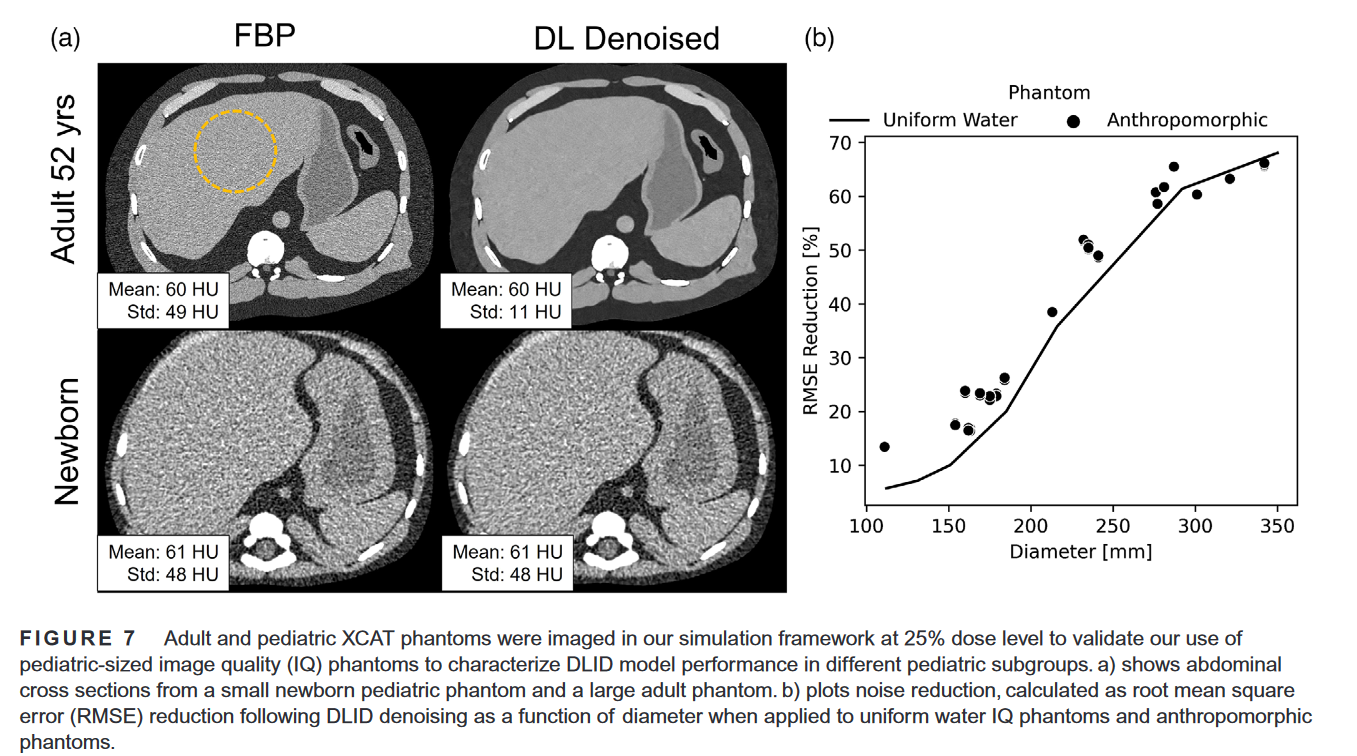

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) & (results['effective diameter [cm]'] != 20)],
             x='effective diameter [cm]', y='RMSE [HU]', style='phantom', hue='recon', hue_order=recon_order) 

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter [cm]'] != 20) &
                          (results['recon'] != 'fbp') &
                          (results['phantom'] != 'MITA-LCD')],
             x='effective diameter [cm]',
             y='RMSE reduction [%]',
             style='phantom',
             style_order=['uniform', 'anthropomorphic'],
             hue='recon',
             hue_order=recon_order[1:]) 

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) & (results['effective diameter [cm]'] != 20)],
             x='effective diameter [cm]', y='noise std [HU]', style='phantom', hue='recon', hue_order=recon_order[1:]) 

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter [cm]'] != 20) &
                          (results['recon'] != 'fbp') &
                          (results['phantom'] != 'MITA-LCD')],
             x='effective diameter [cm]',
             y='noise std reduction [%]',
             style='phantom',
             style_order=['uniform', 'anthropomorphic'],
             hue='recon',
             hue_order=recon_order[1:]) 

### Figure 5

In [ ]:
sns.set_context("paper", font_scale=1.5)
sns.set_style("white")
f, axs = plt.subplots(1,2, figsize=(7,3), gridspec_kw=dict(wspace=0.3))
axs=axs.flatten()
for idx, measure in enumerate(['noise std reduction [%]', 'RMSE reduction [%]']):
    legend = True if idx == 0 else False
    sns.lineplot(data=results[(results['Dose [%]']==25) &
                     (results['effective diameter [cm]'] != 20) &
                     (results['phantom'] != 'MITA-LCD') &
                     (results['recon'] != 'fbp')],
                 x='effective diameter [cm]',
                 y=measure,
                 style='phantom',
                 style_order=['uniform', 'anthropomorphic'],
                 hue='recon', 
                 hue_order=['RED-CNN', 'RED-CNN augmented'],
                 ax=axs[idx], legend=legend)
sns.move_legend(
    axs[0], "lower center",
    bbox_to_anchor=(1.1, 1), ncol=2,
)
f.savefig('figures/fig5_noise_reduction.png', dpi=600, bbox_inches='tight')

In [ ]:
sns.barplot(data=results[(results['effective diameter [cm]']!=20) &
           (results['Dose [%]'] == 25)],
            x='recon',
            y='noise std reduction [%]',
            hue='Dose [%]', capsize=0.15)

In [ ]:
sns.barplot(data=results[results['effective diameter [cm]']!=20],
            x='recon',
            y='noise std reduction [%]',
            hue='Dose [%]',
            capsize=0.15)

In [ ]:
sns.barplot(data=results[(results['effective diameter [cm]']!=20)  & (results['Dose [%]'] == 25)],
            x='recon',
            y='RMSE reduction [%]',
            hue='Dose [%]',
            capsize=0.15)

In [ ]:
redaug_rmse_reduction_mean = results[(results['effective diameter [cm]']!=20)  &
                                     (results['Dose [%]'] == 25)  &
                                     (results['recon'] == 'RED-CNN augmented')]['RMSE reduction [%]'].mean()
red_rmse_reduction_mean = results[(results['effective diameter [cm]']!=20)  &
                                  (results['Dose [%]'] == 25)  &
                                  (results['recon'] == 'RED-CNN')]['RMSE reduction [%]'].mean()

redaug_std_reduction_mean = results[(results['effective diameter [cm]']!=20)  &
                                     (results['Dose [%]'] == 25)  &
                                     (results['recon'] == 'RED-CNN augmented')]['noise std reduction [%]'].mean()
red_std_reduction_mean = results[(results['effective diameter [cm]']!=20)  &
                                  (results['Dose [%]'] == 25)  &
                                  (results['recon'] == 'RED-CNN')]['noise std reduction [%]'].mean()
print('Averaged across all diameters')
print(f'RED-CNN noise std [HU] reduction {red_std_reduction_mean:2.2f}\nRED-CNN augmented RMSE reduction {redaug_std_reduction_mean:2.2f}')
print('-----')
print(f'RED-CNN RMSE reduction {red_rmse_reduction_mean:2.2f}\nRED-CNN augmented RMSE reduction {redaug_rmse_reduction_mean:2.2f}')

In [ ]:
from utils import pediatric_subgroup
results['pediatric subgroup'] = results['effective diameter [cm]'].apply(pediatric_subgroup)
results

In [ ]:
recons = recon_order
for subgroup in ['newborn', 'infant', 'child', 'adolescent', 'adult']:
    print('-------')
    print(subgroup)
    for recon in recons:
        mean_noise_reduction = results[(results['effective diameter [cm]']!=20)  &
                                       (results['Dose [%]'] == 25)  &
                                       (results['recon'] == recon) &
                                       (results['pediatric subgroup'] == subgroup)]['noise std reduction [%]'].mean()
        print(f'{recon} noise std [HU] reduction: {mean_noise_reduction:2.2f} %')

In [ ]:
results[(results['effective diameter [cm]']!=20)  &
        (results['Dose [%]'] == 25)  &
        (results['recon'] == 'RED-CNN') &
        (results['pediatric subgroup'] == 'adult')]['noise std reduction [%]'].mean()

In [ ]:
results[(results['effective diameter [cm]']!=20)  &
        (results['Dose [%]'] == 25)  &
        (results['recon'] == 'RED-CNN') &
        (results['phantom'] != 'anthropomorphic')].sort_values(by='noise std reduction [%]', ascending=False).head()

In [ ]:
redaug_rmse_reduction_mean = results[(results['effective diameter [cm]']!=20) &
                                     (results['Dose [%]'] == 25)  &
                                     (results['recon'] == 'RED-CNN augmented') &
                                     (results['effective diameter [cm]']>30)]['RMSE reduction [%]'].mean()
red_rmse_reduction_mean = results[(results['effective diameter [cm]']!=20) &
                                  (results['Dose [%]'] == 25)  &
                                  (results['recon'] == 'RED-CNN') &
                                  (results['effective diameter [cm]']>30)]['RMSE reduction [%]'].mean()

redaug_rmse_reduction_mean = results[(results['effective diameter [cm]']!=20) &
                                     (results['Dose [%]'] == 25)  &
                                     (results['recon'] == 'RED-CNN augmented') &
                                     (results['effective diameter [cm]']>30)]['noise std reduction [%]'].mean()
red_rmse_reduction_mean = results[(results['effective diameter [cm]']!=20) &
                                  (results['Dose [%]'] == 25)  &
                                  (results['recon'] == 'RED-CNN') &
                                  (results['effective diameter [cm]']>30)]['noise std reduction [%]'].mean()
print('Averaged across diameters > 30 cm')
print(f'RED-CNN noise std [HU] reduction {red_std_reduction_mean:2.2f}\nRED-CNN augmented RMSE reduction {redaug_std_reduction_mean:2.2f}')
print('-----')
print(f'RED-CNN RMSE reduction {red_rmse_reduction_mean:2.2f}\nRED-CNN augmented RMSE reduction {redaug_rmse_reduction_mean:2.2f}')

In [ ]:
results[(results['effective diameter [cm]']!=20)  & (results['Dose [%]'] == 25)  & (results['recon'] == 'RED-CNN augmented')]['noise std reduction [%]'].mean()

In [ ]:
results[(results['effective diameter [cm]']!=20)  & (results['Dose [%]'] == 25)  & (results['recon'] == 'RED-CNN')]['noise std reduction [%]'].mean()

In [ ]:
sns.barplot(data=results[(results['effective diameter [cm]']!=20)], x='recon', y='RMSE reduction [%]', hue='Dose [%]', capsize=0.15)

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) & (results['effective diameter [cm]'] != 20)], x='effective diameter [cm]', y='noise std reduction [%]', style='phantom', hue='recon', hue_order=recons[1:]) 
# plt.savefig('std_reduction.png', dpi=600)

In [ ]:
from utils import adult_waist_circumferences_cm, age_to_eff_diameter

adult_waist_diam_mm = {a: c/np.pi for a,c in adult_waist_circumferences_cm.items()}
adult_waist_diam_mm

ages = np.linspace(0, 18,1000)
eff_diameters = np.array(list(map(age_to_eff_diameter, ages)))

ages = np.append(ages, list(adult_waist_diam_mm.keys()))
eff_diameters = np.append(eff_diameters, list(adult_waist_diam_mm.values()))

plt.plot(ages, eff_diameters)
plt.xlabel('age [yrs]')
plt.ylabel('mean effective waist diameter [mm]')

In [ ]:
def diameter_range_from_subgroup(subgroup):
    if subgroup == 'newborn': return (0, age_to_eff_diameter(1/12))
    elif subgroup == 'infant': return (age_to_eff_diameter(1/12), age_to_eff_diameter(2))
    elif subgroup == 'child': return (age_to_eff_diameter(2), age_to_eff_diameter(12))
    elif subgroup == 'adolescent': return (age_to_eff_diameter(12), age_to_eff_diameter(22))
    else: return (age_to_eff_diameter(22), 100)

In [ ]:
d = {group: diameter_range_from_subgroup(group) for group in results['pediatric subgroup'].unique()}
pd.DataFrame({'subgroup':d.keys(), 'age bin start':[0, 1/12, 2, 12, 22], 'effective diameter bin start [cm]': [o[0] for o in d.values()]})

In [ ]:
f, axs = plt.subplots(1,2, figsize=(11,3))
for idx, measure in enumerate(['noise std reduction [%]', 'RMSE reduction [%]']):
    legend = True if idx < 1 else False 
    sns.barplot(ax=axs[idx], data=results[(results['effective diameter [cm]']!=20)  & (results['Dose [%]'] == 25)], x='recon', y=measure, order=recons, hue='pediatric subgroup', capsize=0.15, legend=legend)
sns.move_legend(
    axs[0], "lower center",
    bbox_to_anchor=(1.1, 1), ncol=5, frameon=False
)
# plt.savefig('subgroup_denoising_comparison.png', dpi=600, bbox_inches='tight')

### Figure 6

In [ ]:
sns.set_context("paper", font_scale=1.25)
f, ax = plt.subplots(figsize=(7,4))
measure = 'noise std reduction [%]'
sns.barplot(data=results[(results['effective diameter [cm]']!=20) &
                         (results['Dose [%]'] == 25) & 
                         (results['recon'] != 'fbp')], x='recon', y=measure, order=['RED-CNN','RED-CNN augmented'], hue='pediatric subgroup', capsize=0.15, ax=ax)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, 1), ncol=5, frameon=False,
)
ax.set_ylim([40, 80])
plt.savefig('figures/fig6_subgroup_denoising_std_comparison.png', dpi=600, bbox_inches='tight')

### Figure 9b

In [ ]:
sns.set_context('paper', font_scale=1.2)
f, ax = plt.subplots(dpi=300)
f, ax = make_montage(meta.replace({'fbp':'FBP'}), phantom='ACR464',recons = ['FBP', 'RED-CNN', 'RED-CNN augmented'],  roi_diameter=0.4, fovs=[38, 15], crop_to_fit=False, wwwl=(150, 0), figure=f, axis=ax, fontsize=9)
ax.set_title(ax.get_title().replace('Recon', 'Physical Scan'))
f.savefig('figures/fig9b_physical_validation.png', dpi=600)

In [ ]:
from utils import noise_reduction
print(f'38 cm: RED-CNN - {noise_reduction(50, 13):2.2f}% RED-CNN augmented - {noise_reduction(51, 13):2.2f}%')
print(f'25 cm: RED-CNN - {noise_reduction(51, 21):2.2f}% RED-CNN augmented - {noise_reduction(51, 14):2.2f}%')
print(f'15 cm: RED-CNN - {noise_reduction(51, 34):2.2f}% RED-CNN augmented - {noise_reduction(51, 21):2.2f}%')

In [ ]:
plt.figure(dpi=300)
make_montage(meta, phantom='ACR464', roi_diameter=0.4, fovs=[38], crop_to_fit=True, wwwl=(150, 0))

In [ ]:
plt.figure(dpi=300)
make_montage(meta, phantom='ACR464', roi_diameter=0.4, fovs=[38, 25, 15], crop_to_fit=True, wwwl=(150, 0))

### Figure 9c

In [ ]:
sns.set_context('paper', font_scale=1.2)
f, ax = plt.subplots(dpi=300)
make_montage(meta.replace({'fbp':'FBP'}), phantom='uniform', recons = ['FBP', 'RED-CNN', 'RED-CNN augmented'], roi_diameter=0.4, fovs=[39, 14], crop_to_fit=True, wwwl=(150, 0), figure=f, axis=ax, fontsize=9)
ax.set_title(ax.get_title().replace('Recon', 'Simulated Scan'))

In [ ]:
means = results.groupby(['phantom', 'Dose [%]', 'pediatric subgroup','recon'])['noise std reduction [%]'].mean()
means['anthropomorphic'][25].astype(int)

In [ ]:
means = results.groupby(['phantom', 'Dose [%]', 'pediatric subgroup','recon'])['RMSE reduction [%]'].mean()
means['anthropomorphic'][25].astype(int)

It was aliasing! this shows tha the anthropomorphic does track with uniform and that augmentation does help the smallest patients in terms of RMSE reduction as well

In [ ]:
patient = results[(results.phantom == 'anthropomorphic') & (results.recon != 'fbp') ].sort_values(by='RMSE reduction [%]').iloc[0]
print(patient)
plt.figure(dpi=300)
ctshow(load_mhd(anthro_dir / patient.file)[0])

In [ ]:
patient = results[(results.phantom == 'anthropomorphic') & (results.recon != 'fbp') & (results['Dose [%]'] == 25)].sort_values(by='RMSE reduction [%]').iloc[0]
print(patient)
img = load_mhd(anthro_dir / patient.file)[0] 
gt = load_mhd(anthro_dir / get_ground_truth(patient.file))
plt.figure(dpi=300)
ctshow(np.concatenate([gt, img], axis=1))

In [ ]:
plt.figure(dpi=300)
ctshow(img-gt)
plt.colorbar()

In [ ]:
patient = results[(results.phantom == 'anthropomorphic') & (results.recon != 'fbp') & (results['Dose [%]'] == 25)].sort_values(by='RMSE reduction [%]').iloc[-1]
print(patient)
img = load_mhd(anthro_dir / patient.file)[0] 
gt = load_mhd(anthro_dir / get_ground_truth(patient.file))
plt.figure(dpi=300)
ctshow(np.concatenate([gt, img], axis=1))

In [ ]:
plt.figure(dpi=300)
ctshow(img-gt)
plt.colorbar()

**Why is it that infants have greater RMSE reduction than adults? This is contrary to the previous paper...**

ALIASING?? Could that be it, but im using the same phantoms (in the previous paper I used the *true* phantom - free of aliasing as the truth, not the noiseless one), trying using true.mhd rather than noise free 

Yes it was aliasing, the one mystery remaining is why anthro slightly overperformed in the paper and now slightly under performs, this could be a noise thing or a definition thing but its not as big of a deal

In [ ]:
plt.figure(dpi=300)
make_montage(meta, fovs = [14.43, 35.88], phantom = 'anthropomorphic', roi_center='liver', roi_diameter=0.3, wwwl='soft tissues', crop_to_fit=True)

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter [cm]'] != 20) &
                          (results['recon'] != 'fbp')], x='effective diameter [cm]', y='RMSE reduction [%]', style='phantom', hue='recon', hue_order=recons[1:]) 

This basically replicates Fig 7 from Nelson 2023, but now with the augmentation in place. Can also show in terms of noise reduction which might be more compelling too

In [ ]:
temp = results[(results.recon=='fbp') &
        (results.simulated==True) &
        (results['sim number']==1) &
        (results.phantom != 'anthropomorphic')]
sns.histplot(x='effective diameter [cm]', data=temp, hue='pediatric subgroup',
             hue_order=['newborn', 'infant', 'child', 'adolescent', 'adult'], bins=9)

In [ ]:
age_to_eff_diameter(5)

In [ ]:
diams = np.array(sorted(temp['effective diameter [cm]'].unique()))
x = np.linspace(min(diams), max(diams), len(diams))
plt.scatter(x, diams, label='experimental sample')
plt.plot(x,x,label='identity')
plt.scatter(x, sorted(np.random.uniform(10, 40, len(diams))), label='rand uniform sample')
plt.xlabel('diameter [cm]')
plt.ylabel('sampled diameter [cm]')

# ylvl=188
# plt.fill_between(x, max(diams), min(diams),  where=age_to_eff_diameter(ages) < age_to_eff_diameter(1), facecolor='red', alpha=.5)
# plt.annotate('Newborn', (0.5, 150), xytext=(-0.75, ylvl+15))

# plt.fill_between(x, diams.max(), diams.min(),  where=(ages >= 1) & (ages < 5), facecolor='orange', alpha=.5)
# plt.annotate('Infant', (2, 200), xytext=(2, ylvl))

# plt.fill_between(x, diams.max(), diams.min(),  where=(ages >= 5) & (ages < 12), facecolor='yellow', alpha=.5)
# plt.annotate('Child', (2.5, 200), xytext=(7.5, ylvl))

# plt.fill_between(x, diams.max(), diams.min(),  where=(ages >= 12) & (ages < 19), facecolor='green', alpha=.5)
# plt.annotate('Adolescent', (2.5, 200), xytext=(12, ylvl))
# plt.show()
plt.legend()
plt.show()

In [ ]:
results.phantom.unique()

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter [cm]'] != 20) &
                          (results.phantom=='uniform') & 
                          (results.simulated==True)], x='effective diameter [cm]', y='noise std [HU]', hue='recon')

In [ ]:
f, ax = plt.subplots()
phantom = 'uniform'
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results.phantom==phantom)],
             x='FOV [cm]',
             y='noise std [HU]',
             hue='recon',
             style='simulated',
             style_order=[True, False], ax=ax)
ax.set_title(f'{phantom} phantom')

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp') & (results.simulated == True)],
             x='FOV [cm]',
             y='noise std reduction [%]',
             hue='recon')
# plt.savefig('noise_std_reduction.png', dpi=600)

### Figure 9d

In [ ]:
sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
f, ax = plt.subplots(figsize=(4,3), dpi=300)
results['series'] = results.simulated.apply(lambda o: 'simulated' if o else 'physical')
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp')], x='FOV [cm]', y='noise std reduction [%]', hue='recon', hue_order=['RED-CNN', 'RED-CNN augmented'], style='series', style_order=['simulated', 'physical'], ax=ax)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, 1), ncol=2, frameon=False
)
plt.savefig('figures/fig9d_uniform_phantom_physical_validation.png', dpi=600)

In [ ]:
f, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,4), dpi=150)
sns.lineplot(data=results[(results.phantom=='uniform') &
                          (results.simulated==True) &
                          (results.recon != 'fbp')], x='FOV [cm]', y='noise std reduction [%]', hue='Dose [%]', style='recon', ax=axs[0])
axs[0].set_title('Simulated')
sns.lineplot(data=results[(results.phantom=='uniform') &
                          (results.simulated==False) &
                          (results.recon != 'fbp')], x='FOV [cm]', y='noise std reduction [%]', hue='Dose [%]', style='recon', ax=axs[1])
axs[1].set_title('Real')
f.suptitle('Uniform Water Phantom')
# plt.savefig('uniform_phantom_physical_validation.png', dpi=600)

Looks like the models behave pretty uniformly for dose levels in between quarter dose (25%) and full dose (100%) but for really low doses below the low dose training inputs, such as 15% dose, both RED-CNN and augmented RED-CNN underperform indicated that going for a dose even lower than what was seen during training is also considered out of distribution whereas doses in between training min and max act as in distribution.

## Bonus: Noise Reduction in Adult Patient Images
From Held out low dose grand challenge dataset. Same clinical site and scanner as training set but different patients.

In [ ]:
import sys
import os
import torch
sys.path.append('../denoising')
from networks import RED_CNN

In [ ]:
from collections import OrderedDict

def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

base_denoising_model  = load_model('../denoising/models/redcnn')
aug_denoising_model = load_model('../denoising/models/redcnn_augmented')

In [ ]:
test_input = np.load('../data/Denoising_Data/test_input.npy').squeeze()
test_target = np.load('../data/Denoising_Data/test_target.npy').squeeze()

nexample = 2
base_CNNout = base_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()
aug_CNNout = aug_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()

In [ ]:
plt.figure(figsize=(16, 8), tight_layout=True)

plt.subplot(2, 2, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[3, 110:-110, 50:-50])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50])

plt.subplot(2, 2, 3)
plt.title('Base Denoiser', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50])

plt.subplot(2, 2, 4)
plt.title('Denoiser with Augmentation', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50])
plt.savefig(f'images/test_patient.png', dpi=600, bbox_inches='tight')

In [ ]:
import pydicom

ld_dir = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/figures/L506/quarter_3mm/')
fd_dir = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/figures/L506/full_3mm/')
adult_ld_dcm_files = sorted(list(ld_dir.glob('*.IMA')))
adult_fd_dcm_files = sorted(list(fd_dir.glob('*.IMA')))

In [ ]:
adult_ld_dcm_files[:5], adult_fd_dcm_files[:5]

In [ ]:
import SimpleITK as sitk
def load_dcm_img(dcm_file):
    if isinstance(dcm_file, sitk.Image): return sitk.GetArrayFromImage(dcm_file)
    dcm = pydicom.read_file(dcm_file)
    return dcm.pixel_array + float(dcm.RescaleIntercept)

In [ ]:
idx = 30
ld = load_dcm_img(adult_ld_dcm_files[idx])
rd = load_dcm_img(adult_fd_dcm_files[idx])
ctshow(ld)

In [ ]:
denoised = base_denoising_model.predict(ld).squeeze()

In [ ]:
ctshow(denoised)

In [ ]:
augmented = aug_denoising_model.predict(ld).squeeze()

In [ ]:
ctshow(augmented)

In [ ]:
plt.figure(dpi=300)
ctshow(np.concatenate([np.concatenate([ld, rd], axis=1),
                      np.concatenate([denoised, augmented], axis=1)], axis=0))

In [ ]:
plt.figure(dpi=300)
ctshow(np.concatenate([ld-rd, ld-denoised, ld-augmented],axis=1), (200, 0))

In [ ]:
ctshow(np.concatenate([rd - ld, rd-denoised, rd-augmented],axis=1), (200, 0))

In [ ]:
rmses = {v: rmse(k, rd) for (k, v) in zip([ld, denoised, augmented], ['low dose', 'redcnn', 'redcnn-aug'])}
rmses

In [ ]:
adult_fd_images = np.array([load_dcm_img(o) for o in sorted(adult_fd_dcm_files)])
adult_ld_images = np.array([load_dcm_img(o) for o in sorted(adult_ld_dcm_files)])
adult_fd_images.shape, adult_ld_images.shape

In [ ]:
base_denoising_model.to('cuda')
base_denoising_model.predict(adult_ld_images[:,None,:,:], device='cuda', batch_size=32);

In [ ]:
rmse(adult_fd_images, adult_ld_images)

In [ ]:
batch_size=32
device = 'cuda'

series_rmse = ['low dose', 'redcnn', 'redcnn-aug']
res = np.zeros((len(series_rmse), len(adult_ld_dcm_files)))
adult_fd_images = np.array([load_dcm_img(o) for o in sorted(adult_fd_dcm_files)])
adult_ld_images = np.array([load_dcm_img(o) for o in sorted(adult_ld_dcm_files)])

for d_idx, (denoiser, name) in enumerate(zip([None, base_denoising_model, aug_denoising_model], series_rmse)):
    if denoiser is None:
       res[0, :] = list(map(lambda x, y: rmse(x, y), adult_ld_images, adult_fd_images))
    else:
        denoiser.to(device)
        denoised = denoiser.predict(adult_ld_images[:, None,:,:], device=device, batch_size=batch_size).squeeze()
        res[d_idx, :] = list(map(lambda x, y: rmse(x, y), denoised, adult_fd_images))

In [ ]:
rmse_df = pd.DataFrame(data=res.T, columns = series_rmse)
rmse_df['full dose file'] = str(adult_fd_dcm_files)
rmse_df['quarter dose file'] = str(adult_ld_dcm_files)
rmse_df

In [ ]:
sns.violinplot(data=rmse_df)
plt.ylabel('RMSE')
plt.title('Adult Real Patient Test Data from Mayo')

In [ ]:
sns.scatterplot(data=rmse_df,x='low dose', y='redcnn', label='redcnn')
sns.scatterplot(data=rmse_df,x='low dose', y='redcnn-aug', label='redcnn aug')
plt.ylabel('RMSE')
plt.legend()

The fact that the augmented model underperforms the original model when tested on *adult* data is unsurprising, our hypothesis is that it would act as a regularizer and yield more consistent performance in *smaller* patients, need to explore this next

## Physical Phantom Validation

Using dataset prepared in [physical_validation.ipynb](physical_validation.ipynb)

## Conclusions

This can have the merged uniform and anthro rmse reduction plot like in Nelson et al 2023